# 連結 Google Drive

In [ ]:
from google.colab import drive
drive.mount( '/content/gdrive' )

# 檢視分配到的 GPU 資源

In [2]:
!nvidia-smi 

Tue Sep 15 21:36:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 匯入套件

In [3]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from timeit import default_timer as timer
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  
import warnings
warnings.filterwarnings( 'ignore' )

# 確保 Colob 中使用的 TensorFlow 是 1.X 版本而不是 TensorFlow 2.X
try:
    %tensorflow_version 1.x 
except Exception:
    pass

import tensorflow as tf 

# 需安裝 Keras 2.2.4 的版本
!pip install keras==2.2.4
import keras
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
print( '\nTensorFlow 的版本:', tf.__version__ )
print( 'Keras 的版本:', keras.__version__ )

TensorFlow 1.x selected.
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3

TensorFlow 的版本: 1.15.2
Keras 的版本: 2.2.4


Using TensorFlow backend.


# 下載 YOLO V3 程式碼

In [4]:
os.chdir( '/content/gdrive/My Drive' )

# 下載 YOLO V3 程式碼
if not os.path.exists( 'keras-yolo3' ):
    print( "YOLO V3 code doesn't exist, downloading..." )
    !git clone https://github.com/qqwweee/keras-yolo3
    print( 'YOLO V3 code download completed' )
    os.chdir( '/content/gdrive/My Drive/keras-yolo3' ) 
    
else:  
    print( "YOLO V3 code exists." )
    os.chdir( '/content/gdrive/My Drive/keras-yolo3' )

YOLO V3 code exists.


## 預訓練模型的權重  

下載 YOLO V3 的網路權重，且轉換成 Keras 能夠讀取的格式...

In [5]:
# 下載 YOLO V3 的網路權重( 且轉換成 Keras 能夠讀取的格式 )
if not os.path.exists( 'model_data/yolo.h5' ):
  print( "Model doesn't exist, downloading..." )
  os.system( 'wget https://pjreddie.com/media/files/yolov3.weights' )
  print( 'Converting yolov3.weights to yolo.h5...' )
  os.system( 'python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5' )
else:
  print( 'Model exists.' )

Model exists.


In [6]:
if not os.path.exists( 'model_data/yolo_weights.h5' ):
    print( 'Converting pretrained YOLO V3 weights for training...' )
    # '-w': 代表只轉換 yolov3.weights 到 model_data/yolo_weights.h5
    os.system( 'python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5' ) 
    print( 'Pretrained weights convert completed.' )
else:
    print( 'Pretrained weights exists.' )

Pretrained weights exists.


# 下載資料集

- [浣熊(Raccoon)資料集](https://github.com/experiencor/raccoon_dataset)  
- [袋鼠(Kangaroo)資料集](https://github.com/experiencor/kangaroo)

In [7]:
os.chdir( '/content/gdrive/My Drive/keras-yolo3' )

if not os.path.exists( '/content/gdrive/My Drive/keras-yolo3/image_data' ):
    print( "Image folder doesn't exists, creating... " )
    os.makedirs( '/content/gdrive/My Drive/keras-yolo3/image_data' )
    print( 'Image folder is ready.' )
else:
    print( 'Image folder exists.' )  

Image folder exists.


In [8]:
os.chdir( '/content/gdrive/My Drive/keras-yolo3/image_data' )

# 浣熊(Raccoon)資料集
if not os.path.exists( 'raccoon_dataset' ):
    print( "raccoon_dataset doesn't exist, downloading..." )
    !git clone https://github.com/experiencor/raccoon_dataset
    print( 'raccoon_dataset download completed.' )
else:
    print( 'raccoon_dataset exists.' )
    
# 袋鼠(Kangaroo)資料集
if not os.path.exists( 'kangaroo' ):
    print( "kangaroo doesn't exist, downloading..." )
    !git clone https://github.com/experiencor/kangaroo
    print( 'kangaroo download completed.' )
else:
    print( 'kangaroo exists.' )

raccoon_dataset exists.
kangaroo exists.


# 註解檔(Annotation)   

訓練 YOLO V3 模型時，註解檔的內容格式須為 : image_file_path, x_min, y_min, x_max, y_max, class_id。

In [9]:
os.chdir( '/content/gdrive/My Drive/keras-yolo3' ) 

# 物件類別名稱
classes = [ 'kangaroo', 'raccoon' ]

# 資料集中 annotation 的路徑 
annots_folder_path = [ './image_data/kangaroo/annots', './image_data/raccoon_dataset/annotations' ]  

# 資料集中存放圖片資料夾的路徑
images_folder_path = [ './image_data/kangaroo/images', './image_data/raccoon_dataset/images' ] 

In [10]:
# 定義: 訓練模型用的註解檔轉換函數
def convert_annotation( xml_path, training_annot_file, classes ):
    '''
    xml_path : 各資料集中每張圖片的註解檔路徑
    training_annot_file : 訓練 YOLO V3 時所需要的註解檔
    classes : 訓練 YOLO V3 偵測的物件名稱
    '''
    import xml.etree.ElementTree as ET  # 載入能夠 Parser xml 文件的 library
    with open( xml_path, 'r' ) as f:
        tree = ET.parse(f)
        root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = ( int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), 
              int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text) )
        training_annot_file.write( " " + ",".join([str(a) for a in b]) + ',' + str(cls_id) )

產製訓練 YOLO V3 模型時所需要的註解檔...

In [11]:
if not os.path.exists( '/model_data/Raccoon_and_kangaroo.txt' ):
    print( "Raccoon_and_kangaroo.txt doesn't exists, converting ... " )

    with open( './model_data/Raccoon_and_kangaroo.txt', 'w' ) as to_file:
        
        for annots_folder, images_folder in zip( annots_folder_path, images_folder_path ):
            
            annotation_files = os.listdir( annots_folder )  # 註解資料夾中所有的檔案名稱
            for annofile in annotation_files:
                file_name = annofile.split('.')[0]
                to_file.write( os.path.join( images_folder, f'{file_name}.jpg' ) )
                convert_annotation( os.path.join( annots_folder, annofile ), to_file, classes )
                to_file.write('\n')
    print( 'Raccoon_and_kangaroo.txt is ready.' )

else:
    print( 'Raccoon_and_kangaroo.txt exists.' )

Raccoon_and_kangaroo.txt doesn't exists, converting ... 
Raccoon_and_kangaroo.txt is ready.


# 訓練 YOLO V3

## 訓練 YOLO V3 所需的套件 

In [12]:
os.chdir('/content/gdrive/My Drive/keras-yolo3')

# 載入訓練時需要的模組
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

## 訓練 YOLO V3 所需的設定檔

In [13]:
# 每個設定檔的路徑
annotation_path = 'model_data/Raccoon_and_kangaroo.txt'  # 註解檔(Annotation)
classes_path = 'model_data/Raccoon_and_kangaroo_classes.txt'  # 物件偵測類別檔
anchors_path = 'model_data/yolo_anchors.txt'

In [14]:
# 物件偵測類別檔寫入 ./keras-yolo3/model_data 資料夾中
if not os.path.exists( classes_path ):
    print( 'Generating Raccoon_and_kangaroo_classes.txt in ./model_data ...' )
    
    with open( classes_path, 'w' ) as f:
      for cls in classes:
        f.write(cls)
        f.write('\n')
    print( 'Raccoon_and_kangaroo_classes.txt is ready.' )

else:
    print( 'Raccoon_and_kangaroo_classes.txt exists.' )

Raccoon_and_kangaroo_classes.txt exists.


In [15]:
# YOLO V3 訓練完成後的儲存資料夾名稱
log_dir = '/content/gdrive/My Drive/keras-yolo3/logs/Raccoon_and_kangaroo_Model/' 
if not os.path.exists( log_dir ):
    print( "Log folder doesn't exists, creating... " )
    os.makedirs( log_dir )
    print( 'Log folder is ready.' )
else:
    print( 'Log folder exists.' )  

Log folder exists.


## 訓練集與驗證集

In [16]:
# 將資料分割成 training 及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

print( 'Amount of Training = ', num_train  )
print( 'Amount of Validation = ', num_val  )

Amount of Training =  328
Amount of Validation =  36


## 訓練模型 

In [17]:
input_shape = (416,416)  # multiple of 32, hw
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [18]:
is_tiny_version = len(anchors)==6  # Default setting
if is_tiny_version:
    model = create_tiny_model( input_shape, anchors, num_classes,
                               freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5' )
else:
    model = create_model( input_shape, anchors, num_classes,
                          freeze_body=2, weights_path='model_data/yolo_weights.h5' ) 














Create YOLOv3 model with 9 anchors and 2 classes.
Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Callbacks 函數

In [19]:
logging = TensorBoard( log_dir=log_dir )
checkpoint = ModelCheckpoint( log_dir+'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                              monitor='val_loss', save_weights_only=True, save_best_only=True, period=3 )
reduce_lr = ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=3, verbose=1 )
early_stopping = EarlyStopping (monitor='val_loss', min_delta=0, patience=10, verbose=1 )

開始訓練 YOLO V3 模型 ...

In [20]:
# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile( optimizer=Adam(lr=1e-3), 
                   loss={'yolo_loss': lambda y_true, y_pred: y_pred} )  # use custom yolo_loss Lambda layer

    print( 'Stage 1 Training...' )    
    batch_size = 8
    print( 'Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size) )
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model_1 = model.fit_generator( data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                                   steps_per_epoch=max(1, num_train//batch_size),
                                   validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                                   validation_steps=max(1, num_val//batch_size),
                                   epochs=50,
                                   initial_epoch=0,
                                   callbacks=[logging, checkpoint] )
    model.save_weights( log_dir + 'trained_weights_stage_1.h5' )

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile( optimizer=Adam(lr=1e-4), 
                   loss={'yolo_loss': lambda y_true, y_pred: y_pred} ) # recompile to apply the change
    print( 'Unfreeze all of the layers.' )
    print( 'Stage 2 Training...' )  

    batch_size = 8 # note that more GPU memory is required after unfreezing the body
    print( 'Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size) )
    model_2 = model.fit_generator( data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                                   steps_per_epoch=max(1, num_train//batch_size),
                                   validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                                   validation_steps=max(1, num_val//batch_size),
                                   epochs=100,
                                   initial_epoch=50,
                                   callbacks=[logging, checkpoint, reduce_lr, early_stopping] )
    model.save_weights( log_dir+'trained_weights_final.h5' )


Stage 1 Training...
Train on 328 samples, val on 36 samples, with batch size 8.




Epoch 1/50
41/41 [==============================] - 128s 3s/step - loss: 3384.4493 - val_loss: 390.9652

Epoch 2/50
41/41 [==============================] - 23s 573ms/step - loss: 280.9345 - val_loss: 150.7737
Epoch 3/50
41/41 [==============================] - 25s 613ms/step - loss: 146.9229 - val_loss: 103.2045
Epoch 4/50
41/41 [==============================] - 20s 479ms/step - loss: 100.8159 - val_loss: 75.7616
Epoch 5/50
41/41 [==============================] - 25s 608ms/step - loss: 80.6037 - val_loss: 57.6364
Epoch 6/50
41/41 [==============================] - 25s 605ms/step - loss: 66.2138 - val_loss: 50.4614
Epoch 7/50
41/41 [==============================] - 25s 605ms/step - loss: 56.8259 - val_loss: 45.4864
Epoch 8/50
41/41 [==============================] - 25s 607ms/step - loss: 50.7562 - val_loss: 40.9877
Epoch 9/50
41/41 [==============================] - 25s 604ms/step - loss: 44.2538 -

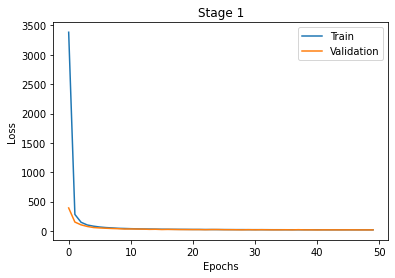

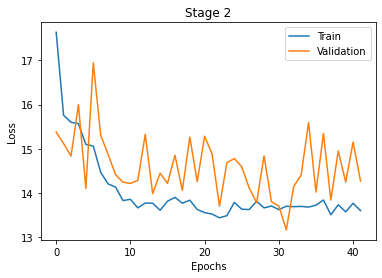

In [21]:
# 第一階段
plt.title('Stage 1') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(model_1.history['loss'], label='Train' )
plt.plot(model_1.history['val_loss'], label='Validation' )
plt.legend( loc='upper right' )
plt.show()

# 第二階段
plt.title('Stage 2') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(model_2.history['loss'], label='Train' )
plt.plot(model_2.history['val_loss'], label='Validation' )
plt.legend( loc='upper right' )
plt.show()

# 下載測試集

存放測試用的圖片及影片資料夾:

In [22]:
os.chdir( '/content/gdrive/My Drive/keras-yolo3' )

if not os.path.exists( '/content/gdrive/My Drive/keras-yolo3/image_data/Raccoon_and_kangaroo_Testing_Data' ):
    print( "Testing folder doesn't exists, creating... " )
    os.makedirs( '/content/gdrive/My Drive/keras-yolo3/image_data/Raccoon_and_kangaroo_Testing_Data' )
    print( 'Testing folder is ready.' )
else:
    print( 'Testing folder exists.' )  

Testing folder doesn't exists, creating... 
Testing folder is ready.


下載測試用的圖片及影片...

In [23]:
os.chdir( '/content/gdrive/My Drive/keras-yolo3/image_data/Raccoon_and_kangaroo_Testing_Data' )

# 測試用圖片
!wget 'https://dehayf5mhw1h7.cloudfront.net/wp-content/uploads/sites/726/2017/08/03065555/Kangacoon-1024x768.jpg'

# 測試用影片
!wget -c 'https://cvdl-fileentity.cupoy.com/2nd/homework/example/1580979702432/Raccoon.mp4'
!wget -c 'https://cvdl-fileentity.cupoy.com/2nd/homework/example/1580979702432/Kangaroo.mp4'

--2020-09-15 22:22:52--  https://dehayf5mhw1h7.cloudfront.net/wp-content/uploads/sites/726/2017/08/03065555/Kangacoon-1024x768.jpg
Resolving dehayf5mhw1h7.cloudfront.net (dehayf5mhw1h7.cloudfront.net)... 99.86.33.143, 99.86.33.87, 99.86.33.146, ...
Connecting to dehayf5mhw1h7.cloudfront.net (dehayf5mhw1h7.cloudfront.net)|99.86.33.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77112 (75K) [image/jpeg]
Saving to: ‘Kangacoon-1024x768.jpg’

Kangacoon-1024x768. 100%[===================>]  75.30K  --.-KB/s    in 0.007s  

2020-09-15 22:22:52 (10.5 MB/s) - ‘Kangacoon-1024x768.jpg’ saved [77112/77112]

--2020-09-15 22:22:52--  https://cvdl-fileentity.cupoy.com/2nd/homework/example/1580979702432/Raccoon.mp4
Resolving cvdl-fileentity.cupoy.com (cvdl-fileentity.cupoy.com)... 13.224.2.11, 13.224.2.5, 13.224.2.96, ...
Connecting to cvdl-fileentity.cupoy.com (cvdl-fileentity.cupoy.com)|13.224.2.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

# 測試圖片

In [24]:
os.chdir('/content/gdrive/My Drive/keras-yolo3' ) 
from yolo import YOLO

yolo_model = YOLO( model_path=log_dir+'trained_weights_final.h5', classes_path=classes_path )

/content/gdrive/My Drive/keras-yolo3/logs/Raccoon_and_kangaroo_Model/trained_weights_final.h5 model, anchors, and classes loaded.


(416, 416, 3)
Found 2 boxes for img
raccoon 1.00 (372, 61) (1024, 737)
kangaroo 1.00 (9, 119) (425, 692)
2.6523683799996434


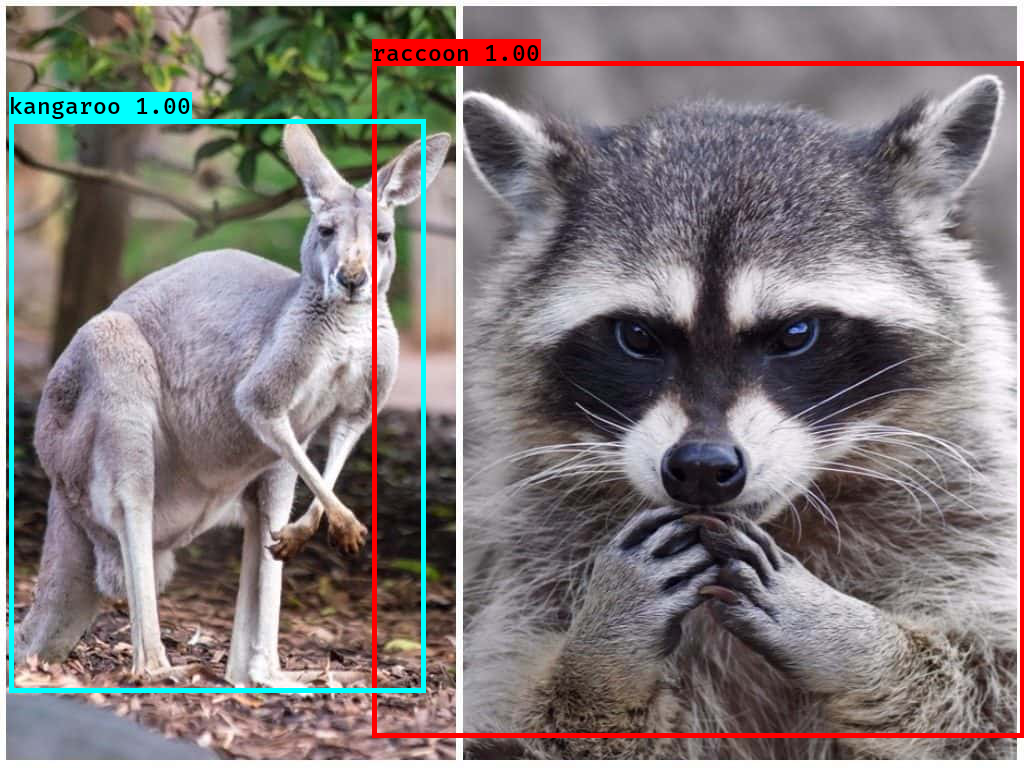

In [25]:
testing_folder = '/content/gdrive/My Drive/keras-yolo3/image_data/Raccoon_and_kangaroo_Testing_Data' 

for img_file in os.listdir( testing_folder ):
    if img_file.split('.')[1]=='jpg':
        image = Image.open( os.path.join(testing_folder,img_file) )  # 讀取測試圖片
        r_image = yolo_model.detect_image(image)  

r_image  

# 測試影片

In [26]:
import time
import cv2

def detect_video(yolo, video_path, output_path=""):
    cap=cv2.VideoCapture(video_path)
    if not cap.isOpened():
      raise IOError("open webcam or video failed!")
       
    FourCC=cv2.VideoWriter_fourcc(*'mp4v')
    fps=cap.get(cv2.CAP_PROP_FPS)
    size=(int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    
    if output_path != "":
      isOutput=True
    else:
      isOutput=False
    
    if isOutput:
      out=cv2.VideoWriter(output_path, FourCC, fps, size)
        
    while(cap.isOpened()):
      ret,frame=cap.read()
                
      if ret==True: 
        # PIL Image transfer
        image=Image.fromarray(np.uint8(frame))                
        image=yolo.detect_image(image)        
        result=np.array(image)        
        
        if isOutput:
          out.write(result)
        
      else:
        break
    
    cap.release()
    out.release()
    
    return

## 偵測浣熊(Raccoon)影片

In [27]:
detect_video( yolo_model, video_path=testing_folder+'/Raccoon.mp4', output_path=testing_folder+'/Raccoon_out.mp4' )
print( 'Detection completed!' )

Streaming output truncated to the last 5000 lines.
0.05267777700009901
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (42, 0) (790, 720)
0.052272690999870974
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (47, 0) (796, 720)
0.05205129400019359
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (0, 8) (1081, 680)
0.05235853100020904
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (85, 0) (749, 720)
0.05376167099984741
(416, 416, 3)
Found 1 boxes for img
raccoon 0.50 (0, 19) (1090, 686)
0.05311487600010878
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (66, 0) (770, 720)
0.052144721999866306
(416, 416, 3)
Found 1 boxes for img
raccoon 0.48 (18, 49) (1055, 658)
0.05250175599985596
(416, 416, 3)
Found 1 boxes for img
raccoon 0.39 (19, 44) (1051, 667)
0.05411599299986847
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (12, 22) (1055, 693)
0.0540508620001674
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (27, 24) (1042, 684)
0.054703148000044166
(416, 416, 3)
Found 1 boxes for img
ra

## 偵測袋鼠(Kangaroo)影片

In [28]:
detect_video( yolo_model, video_path=testing_folder+'/Kangaroo.mp4', output_path=testing_folder+'/Kangaroo_out.mp4' )
print( 'Detection completed!' )

Streaming output truncated to the last 5000 lines.
0.0585769879999134
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.51 (919, 429) (1125, 569)
kangaroo 0.76 (15, 353) (127, 630)
kangaroo 0.88 (203, 282) (906, 651)
0.05712332299981426
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.50 (920, 430) (1125, 569)
kangaroo 0.76 (14, 354) (127, 629)
kangaroo 0.89 (206, 283) (904, 650)
0.06060166699990077
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.57 (897, 425) (1114, 572)
kangaroo 0.59 (6, 313) (127, 667)
kangaroo 0.95 (308, 294) (774, 642)
0.058344558000044344
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.73 (0, 363) (90, 610)
kangaroo 0.79 (724, 312) (1122, 591)
kangaroo 0.96 (299, 283) (788, 657)
0.056680898999729834
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.39 (0, 351) (69, 528)
kangaroo 0.70 (699, 302) (1029, 590)
kangaroo 0.92 (263, 303) (810, 630)
0.05621714600010819
(416, 416, 3)
Found 3 boxes for img
raccoon 0.38 (686, 311) (1021, 636)
kangaroo 0.59 (686, 311) (1021, 636)
kang